In [2]:
%matplotlib inline
import pickle, os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import keras

plt.style.use("seaborn-talk")

Using TensorFlow backend.
/Users/charles/anaconda/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/charles/anaconda/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/charles/anaconda/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/charles/anaconda/envs/

# IPGP Hackathon - 16 November 2019

## Automatic recognition of Raman spectra of minerals

Participants: Alexis Falcin, Lucile Chovo, Matthias, Elodie, Charles Le Losq.



# Why bother ?

Raman spectroscopy is a vibrational spectroscopy that allows observing the inelastic scattering of photons in materials.

For minerals and glasses, this provides a unique signature of their structure. Thus we can use it to recognize minerals and glasses and quantify their proportions as well as the presence of specific elements in them.

# The efforts

There is existing databases like:

    - the [Raman Open Database](http://solsa.crystallography.net/rod/) (European-based project, supported by Horizon 2020), see
    - [RRUFF](http://rruff.info/), an older, geology-focused initiative
    - [Romanian Database of Raman Spectroscopy](http://rdrs.ro)
    
Open source libraries for treatment of spectra are arriving:

    - Rampy in Python
    - Chemospec in R
    - Spectra in Julia

# Why people start to be active in this domain recently ?
![alt text](https://cdn2.nextinpact.com/images/bd/news/170319.jpeg "Title")


# <center>Has the problem be solved ?</center>

Several software already exist but all are closed source, they are usually only good at recognizing endmembers (one mineral), and they are usually tied to either a constructor or a specific database.

e.g. CrystalSleuth for RRUFF, Raman Data Search and Storage for the RDRS...

Plus on the "scientific" side, problems remain unsolved:

    - identification of mixtures of minerals ?
    - how much can we trust estimates ?
    
## This hackathon: What could we do to help ?

# Our dataset

Spectra from 27 minerals from the RRUFF database.

Inputs are the spectra, outputs are the labels (mineral name)

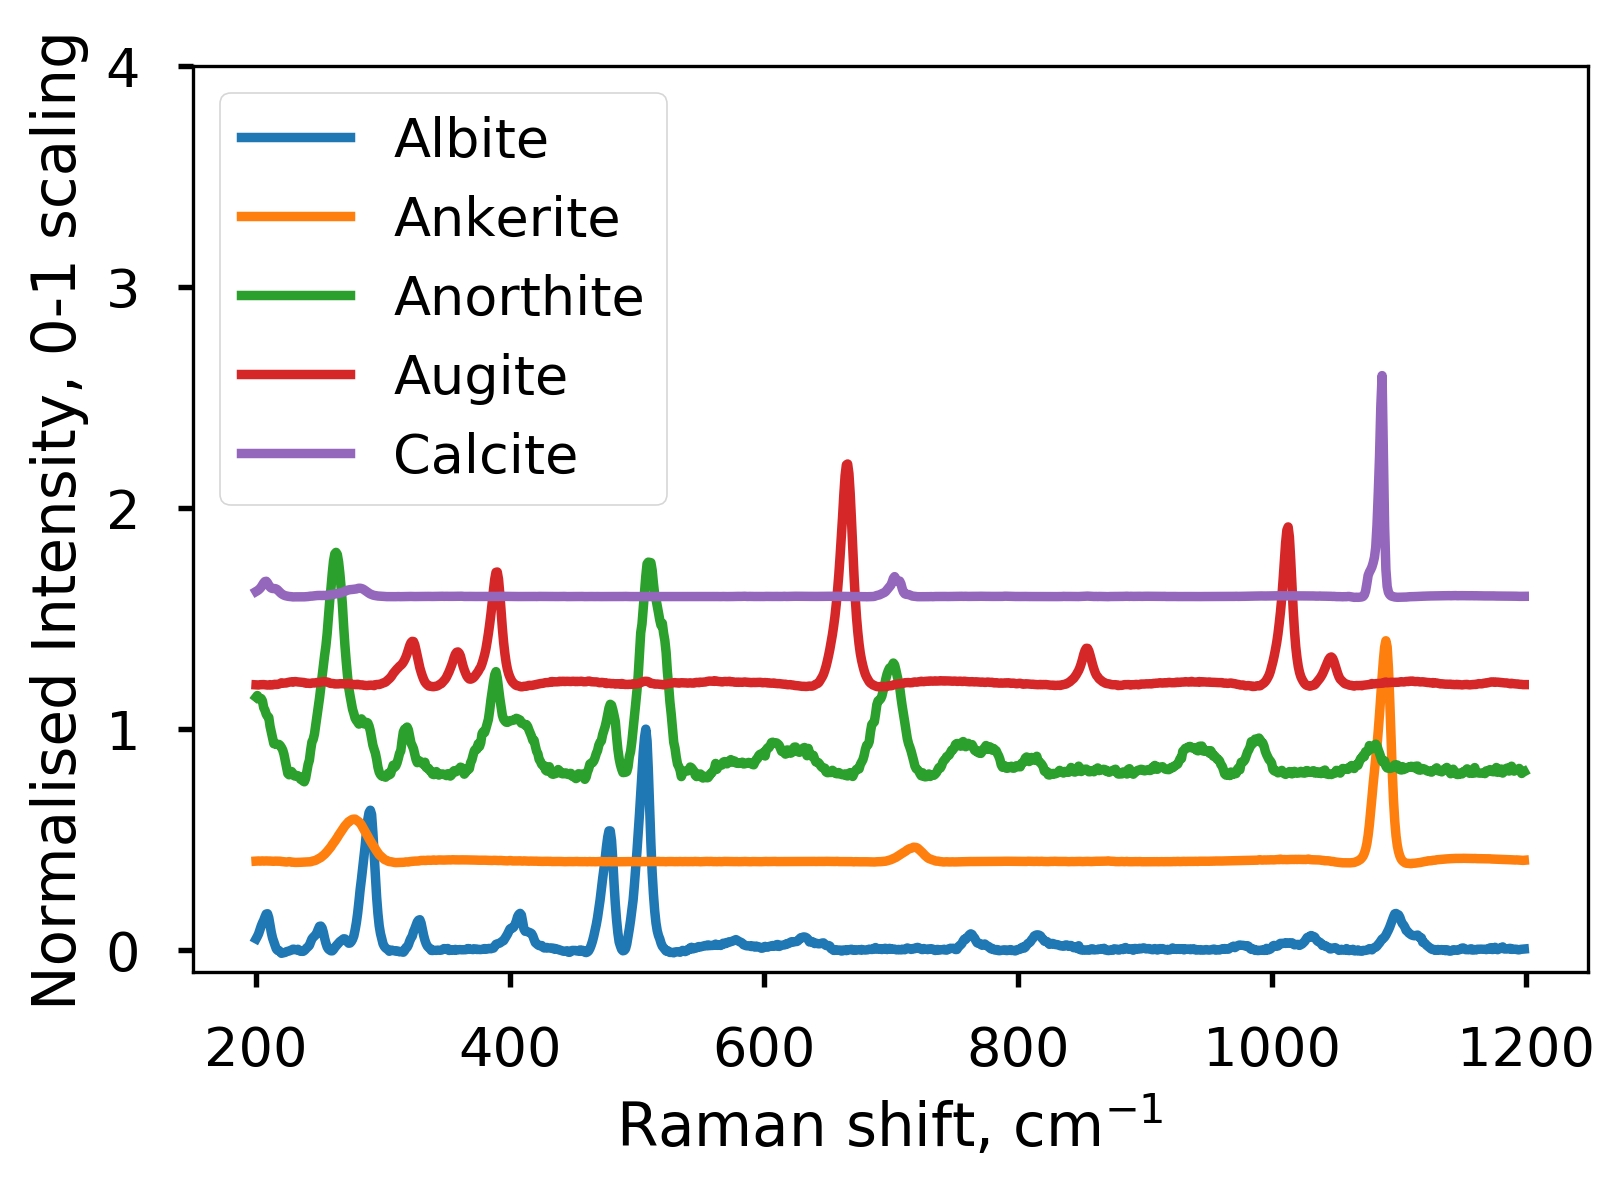

In [20]:
X = np.load('./data/excellent_unoriented/obs.npy')
y_label= pickle.load( open( "./data/excellent_unoriented/labels.pkl", "rb" ) )
y_array = np.load("./data/excellent_unoriented/array_labels.npy")

raman_shift_axis = np.arange(200,1200,1.)

correspondance = pd.read_excel("./data/file_liste_excellent.xlsx",sheet_name="subset_to_train")

plt.figure(figsize=(6,4),dpi=300)

shift = 0
for idx_selected in [1,20,40,60,80]:
    plt.plot(raman_shift_axis,X[idx_selected,:]+shift,label=correspondance.loc[correspondance.loc[:,"label"]==y_label[idx_selected],"mineral"].values[0])
    shift = shift + 0.4
    
plt.xlabel(r"Raman shift, cm$^{-1}$")
plt.ylabel(r"Normalised Intensity, 0-1 scaling")
plt.ylim(-0.1,4)

plt.legend(loc="best")


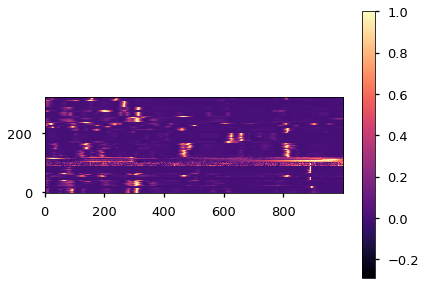

NameError: name 'y' is not defined

In [4]:
plt.imshow(X,cmap='magma')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.colorbar()
plt.show()
print("Il y a "+str(len(y))+" données réparties sur 27 classes")

In [ ]:
correspondance.loc[:,"label"]==0